In [1]:
%matplotlib widget
from i_o import Paths, VolumeReader, get_stimulus
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid, get_clipped_array, AVWriter2

import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import ortho_views_widget


/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
# pn_rec = r"~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/registered.h5" 
# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1501_LB_ZF_v552_f3_40fps_2/registered.h5"
# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/registered.h5"

# dataset_name = "20250818_2159_LB_zf552_25x_f3_audiostim_40fps_1"
dataset_name = "20250828_1718_LB_zf552_para_f1_4"
psf_name = "20250819_1203_PSF_LB_25x_5fps"
bg_name = "20250819_1730_LB_25x_75fps_bg.npy"

# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,)
# paths.registered = paths.registered[:-3]+"_prenorm.h5"
# paths.traces = paths.pn_outrec+"/traces_prenorm.h5"

In [ ]:
reg=lazyh5(paths.registered)
cov_map = reg["cov_map"]
reg

In [ ]:
stim_path = os.path.expanduser(os.path.join(pn_rec, "2025_0818_zf_audiostim","stimset_LB_zf1"))
_, stim_names, stimulus_ids, _,_ = get_stimulus(stim_path, fps = 75,)
stim_names

In [44]:
reader = VolumeReader(paths.registered, "data")
tau = 50
dff_video_fn = paths.registered[:-3] + "_df_video.mp4"
dff_video_writer = AVWriter2(dff_video_fn, fps=75, expected_indeces=reader.i_frames, verbose=False)
average_vol = cp.ones_like(reg["cov_map"], dtype=cp.float32) 
for frame_n, vol in tqdm(reader, desc="dff_vid"):
    
    vol = cp.asarray(vol)
    average_vol = (1/tau) * vol+ (1-1/tau) * average_vol
    dff_vol = vol - average_vol
    dff_mip = create_projection_image(dff_vol[5:-5,:,:],
                            vmax=0.5, vmin=-0.5, absolute_limits=True,
                            zpos=None, scalebar=200, 
                            text=f"{stim_names[stimulus_ids[int(frame_n)]]} f{frame_n}", transpose=True)
    dff_video_writer.write(dff_mip, frame_n)
dff_video_writer.close()

dff_vid:   0%|          | 0/11265 [00:00<?, ?it/s]

OSError: [Errno 5] Can't synchronously read data (file read failed: time = Mon Sep  1 18:03:25 2025
, filename = '/home/lubo12/hpc-rw/lfm/results/20250828_1718_LB_zf552_para_f1_4/registered.h5', file descriptor = 93, errno = 5, error message = 'Input/output error', buf = 0x14d5bf8568f4, total read size = 134794268, bytes this sub-read = 134794268, bytes actually read = 18446744073709551615, offset = 0)

### watershed segmentation

(0.0, 1000.0)

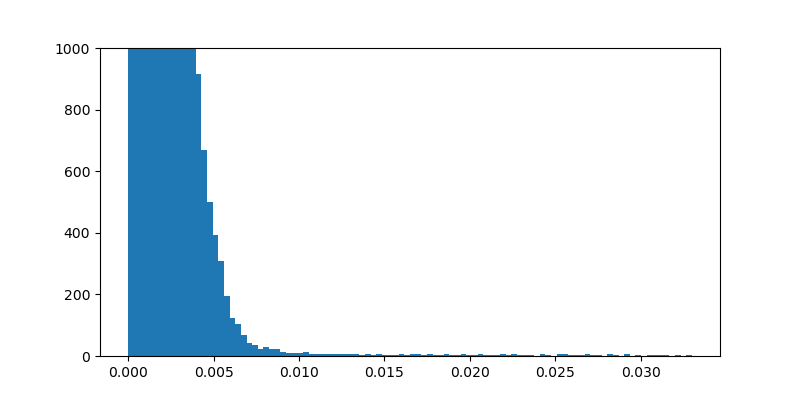

In [6]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
arr =reg["cov_map"].flatten()
ax.hist(arr[np.isfinite(arr)], bins=100)
ax.set_ylim(0,1000)

In [10]:
# cov_map_f = dogfilter_gpu(reg["cov_map"], sigma_low = [1.5,0.5,0.5], sigma_high = [4,4,4])
ortho_views_widget(reg["cov_map"],vmin = 0.00005, vmax=0.0005, absolute_limits = True, transpose = True)

OrthoViewsWidget(coords=[56, 176, 448], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

(1389, 3)
(1390,)
/home/lubo12/hpc-rw/lfm/results/20250818_2111_LB_zf552_f25x_f2_audiostim_40fps_1/segmentation_peaks.tif


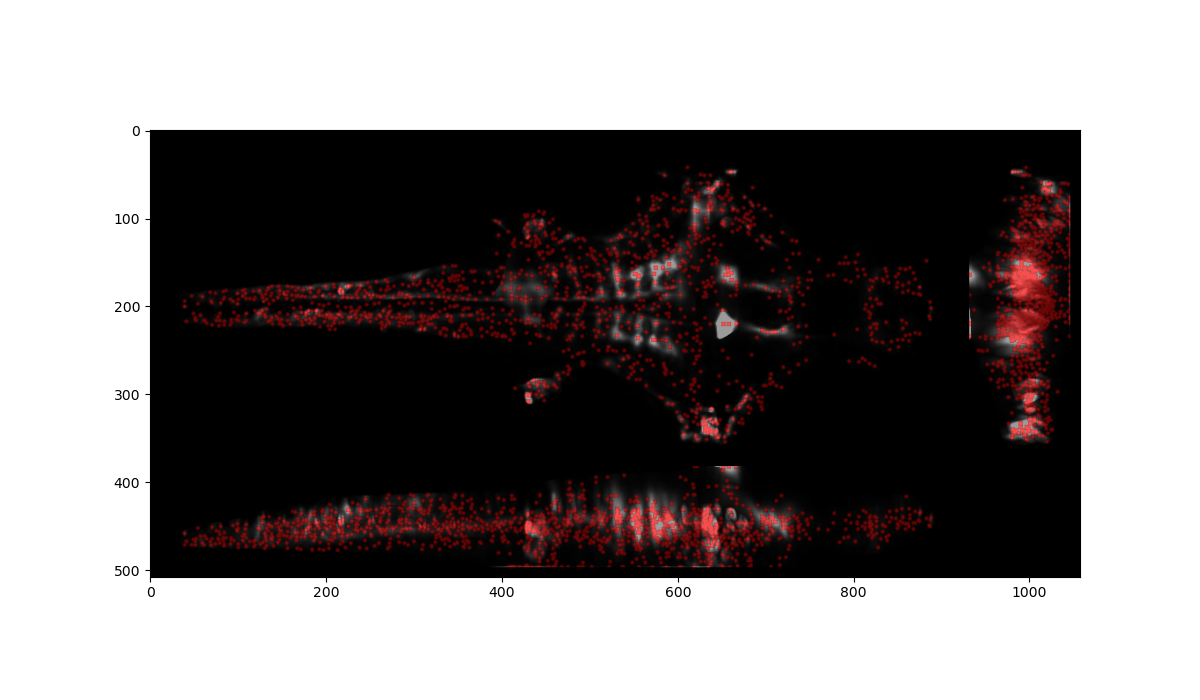

In [14]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy.ndimage import label as ndi_label
from signal_extraction import ball_kernel


cov_map = reg["cov_map"]



peak_min_distance = [3,2,2]
peak_min_brightness=0.0001 #mininum peak brightness for seeding
watershed_start=0.0005 #watershed starts here
watershed_end = 0.00005 #watershed goes until here

peak_coords = peak_local_max(cov_map,
                             footprint=ball_kernel(peak_min_distance),
                             threshold_abs=peak_min_brightness,
                             exclude_border=False)
print(peak_coords.shape)
markers = np.zeros(cov_map.shape, dtype=bool)
markers[tuple(peak_coords.T)] = True
markers, _ = ndi_label(markers)

segmentation_mask = cov_map > watershed_end

labels = watershed(
    -np.clip(cov_map, 0 , watershed_start),  # Flood the inverted landscape
    markers,            # Start flooding from these seeds
    mask=segmentation_mask # Confine flooding to this mask
)
print(np.unique(labels.flatten()).shape)

import signal_extraction
importlib.reload(signal_extraction)
from signal_extraction import dogfilter_gpu, findmaxima_gpu, soft_ball, create_projection_image_with_peaks, save_segmentation_result_tif
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.imshow(create_projection_image_with_peaks(cov_map, peak_coords.T,vmax = 10, marker_radius = [2,2,2], marker_k = 2, marker_intensity=0.8, transpose= True))
tif_output = os.path.join(paths.pn_outrec, "segmentation_peaks.tif")
save_segmentation_result_tif(cov_map, peak_coords.T, output_fn = tif_output, vmax = 10, absolute_limits= False,  marker_radius = [2,2,2], marker_k = 2,)
print(tif_output)


In [15]:
ortho_views_widget(labels, transpose=True)

OrthoViewsWidget(coords=[56, 176, 448], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [17]:
fn = paths.segmentation[:-3]+"_prenorm_watershed.h5"
with h5py.File(fn, "w") as f:
    f.create_dataset("segmentation", data=labels)
lazyh5(fn)
paths.segmentation = paths.segmentation[:-3]+"_prenorm_watershed.h5"

### voxel based segmentation



(0.0, 1000.0)

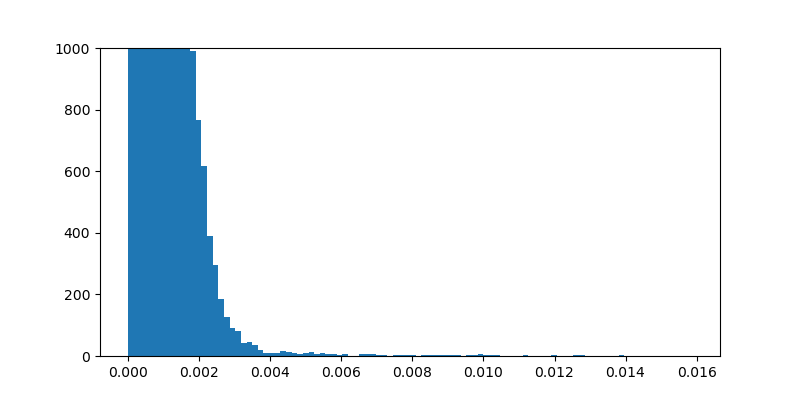

In [8]:
fig, ax = plt.subplots(1,1,figsize = (8,4))
arr =reg["cov_map"].flatten()
ax.hist(arr[np.isfinite(arr)], bins=100)
ax.set_ylim(0,1000)

In [30]:
# cov_map_f = dogfilter_gpu(reg["cov_map"], sigma_low = [1.5,0.5,0.5], sigma_high = [4,4,4])
# z_crop = [0,None]
z_crop = [30,-10]
ortho_views_widget(reg["cov_map"][z_crop[0]:z_crop[1]]*(labels[z_crop[0]:z_crop[1]]!=0),vmin = 0.00001, vmax=0.0001, absolute_limits = True, transpose = True)

OrthoViewsWidget(coords=[80, 208, 400], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [29]:
voxel_size = np.array([3,2,2])
brightness_threshold = 0.00002
cov_map_dwn = cov_map[z_crop[0]:z_crop[1]:voxel_size[0],::voxel_size[1],::voxel_size[2]]

n_voxels = cov_map_dwn[cov_map_dwn >= brightness_threshold].flatten().shape[0]
print(f"{n_voxels} voxels")
voxel_coords=(np.argwhere(cov_map_dwn>= brightness_threshold)*voxel_size + [z_crop[0],0,0])
labels = np.zeros_like(cov_map, dtype = np.uint32)
for i in tqdm(range(n_voxels)):
    coords = voxel_coords[i]
    labels[max(coords[0]-voxel_size[0]//2, 0):min(cov_map.shape[0],coords[0]+voxel_size[0]//2+voxel_size[0]%2),
           max(coords[1]-voxel_size[1]//2, 0):min(cov_map.shape[1],coords[1]+voxel_size[1]//2+voxel_size[1]%2),
           max(coords[2]-voxel_size[2]//2, 0):min(cov_map.shape[2],coords[2]+voxel_size[2]//2+voxel_size[2]%2)] = i+1
ortho_views_widget(labels, transpose=True)

217185 voxels


  0%|          | 0/217185 [00:00<?, ?it/s]

OrthoViewsWidget(coords=[96, 208, 400], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [25]:
labels.shape

(200, 810, 420)

In [31]:
fn = paths.segmentation[:-3]+"_voxels.h5"
with h5py.File(fn, "w") as f:
    f.create_dataset("segmentation", data=labels)
lazyh5(fn)

<IPython.core.display.JSON object>

### trace extraction

In [18]:
import numpy as np
import cupy as cp
from tqdm.auto import tqdm
import cupyx.scipy.ndimage
from i_o import VolumeReader
from signal_extraction import soft_ball
import matplotlib.pyplot as plt


labels_gpu = cp.asarray(labels)

reader = VolumeReader(paths.registered, "data")

unique_labels = cp.unique(labels_gpu)
unique_labels = unique_labels[unique_labels != 0]

traces_mean = np.zeros((reader.get_shape("data")[0], unique_labels.shape[0]))

for i_frame, vol in tqdm(reader, desc="Extracting mean traces"):
    vol_gpu = cp.asarray(vol)
    frame_means = cupyx.scipy.ndimage.mean(vol_gpu, labels=labels_gpu, index=unique_labels)
    traces_mean[i_frame, :] = frame_means.get()



Extracting mean traces:   0%|          | 0/7219 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
np.save(paths.traces[:-3]+"_prenorm_watershed.npy", traces_mean)

In [3]:
paths.segmentation = paths.segmentation[:-3] + "_voxels.h5"
# paths.traces = paths.traces[:-3] + "_watershed.h5"

In [4]:
#on the cluster 
email = 'lukas.born@charite.de' 
#cmd_prefix = ['ssh', 'lubo12@s-sc-frontend1'] # if outside HPC (add your user name), otherwise: 
cmd_prefix = [] #if inside HPC
gres = 'gpu:nvidia_a100_80gb_pcie'
from slurm import PythonExecutorSLURM
slex = PythonExecutorSLURM(job_path=paths.pn_outrec, job_name='trex'+paths.dataset_name, conda_env='lfm1',
                                     time="1-00:00:00", partition="gpu", gres='gpu:1', cpus_per_task=16, mem='256G',ntasks=1,nodes=1,exclude="s-sc-pgpu03",
                           cmd_prefix=cmd_prefix, mail_user=email, mail_type='ALL,TIME_LIMIT_90')


In [5]:
import signal_extraction
importlib.reload(signal_extraction)
from signal_extraction import extract_traces_voxels
job_id = slex.submit(extract_traces_voxels, paths, voxel_size= [3,2,2])
print(paths.dataset_name)

Submitted batch job 6125888

20250828_1718_LB_zf552_para_f1_4


In [47]:
extract_traces_voxels(paths,)

Extracting sum traces:   0%|          | 0/11265 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
traces_mean = np.load(paths.traces[:-3]+"_nonnorm_watershed.npy")

<Axes: >

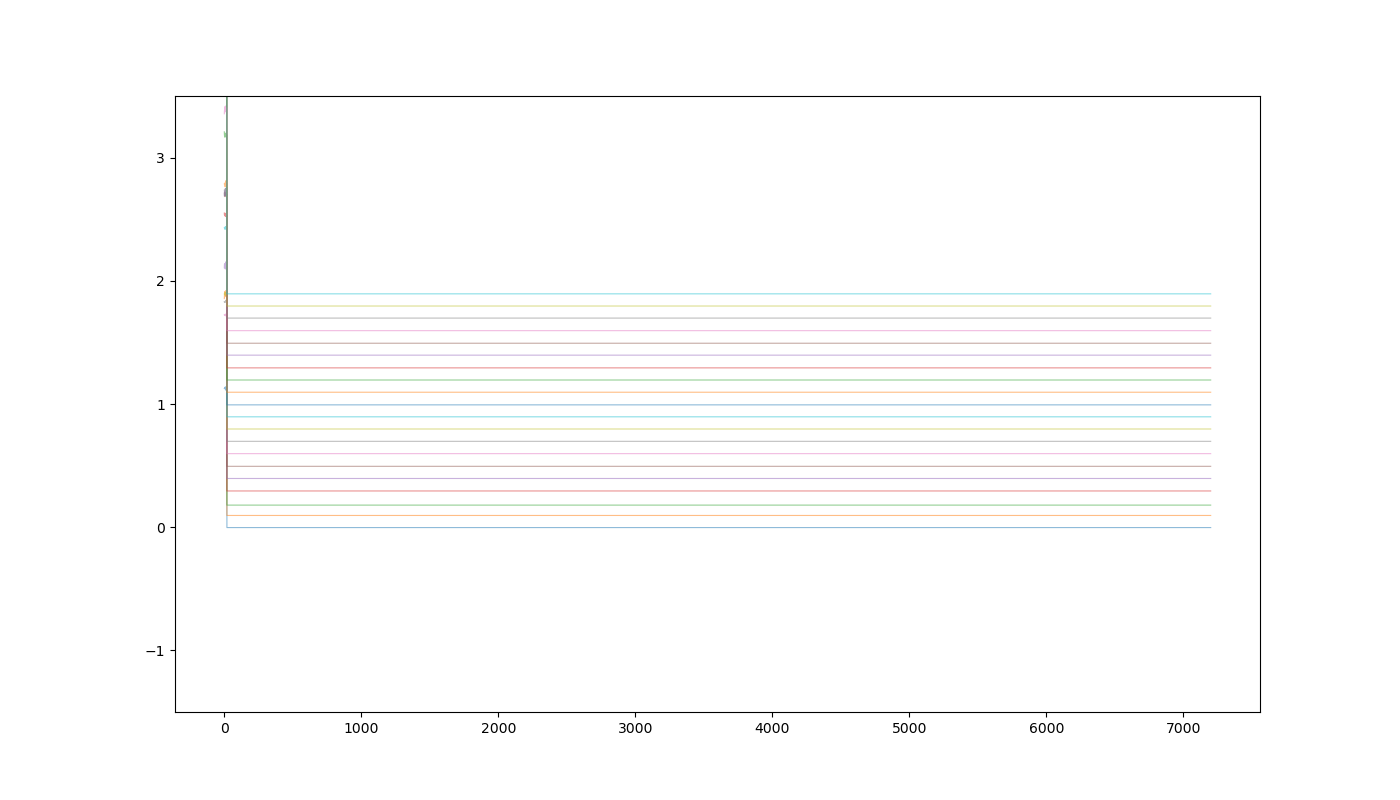

In [111]:
from util import plot_traces
idx = np.random.choice(np.arange(traces_mean.shape[1]), 20)
fig, ax = plt.subplots(1,1,figsize=(14,8))
plot_traces(traces_mean[:7200, idx], np.ones(shape=[7200]), n=20,ax=ax, scale_factor = 0.1, y_add = 1.5)#
# ax.set_ylim(1.5,5.5)

In [98]:
data[trace_mask] = 0.0000001

In [103]:
data -= data.mean(axis=0)

In [38]:
traces_mean[~trace_mask].shape

(73, 1367)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
traces = traces_mean
traces[~trace_mask] = traces.mean(axis=0)


traces_normalized = (traces - traces.mean(axis=0))/traces.std(axis=0)

linked = linkage(traces_normalized.T, method='ward', metric='euclidean')
sort_order = dendrogram(linked, no_plot=True)['leaves']
traces_sorted = traces_normalized[:, sort_order]

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(traces_sorted.T,  aspect="auto", cmap = "bwr") #extent = [traces_sorted.shape[0]/40, 0, 0, traces_sorted.shape[1]]
ax.set_xlabel("Time")
ax.set_ylabel("ROIs")

stim_diff = np.diff(stimulus.astype(int))
stim_starts = np.where(stim_diff == 1)[0] + 1
stim_ends = np.where(stim_diff == -1)[0] + 1



# Overlay vertical spans for stimulus
for start, end in zip(stim_starts, stim_ends):
    ax.axvspan(start , end, color='green', alpha=0.05)



/tmp/ipykernel_932433/3702420179.py:6: RuntimeWarning: invalid value encountered in divide
  traces_normalized = (traces - traces.mean(axis=0))/traces.std(axis=0)


In [58]:
from scipy.cluster.hierarchy import dendrogram, linkage
traces_mean = lazyh5(paths.traces[:-13]+"_prenorm.h5")["traces"]
print(traces_mean.shape)
traces_normalized = (traces_mean - traces_mean.mean(axis=0))/traces_mean.std(axis=0)
linked = linkage(traces_normalized.T, method='ward', metric='euclidean')
sort_order = dendrogram(linked, no_plot=True)['leaves']
traces_sorted = traces_normalized[:, sort_order]

fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(traces_sorted.T, extent = [traces_sorted.shape[0]/40, 0, 0, traces_sorted.shape[1]], aspect="auto", cmap = "bwr")
ax.set_xlabel("Time")
ax.set_ylabel("ROIs")


(7219, 202042)


/tmp/ipykernel_932433/4063849376.py:4: RuntimeWarning: invalid value encountered in divide
  traces_normalized = (traces_mean - traces_mean.mean(axis=0))/traces_mean.std(axis=0)


KeyboardInterrupt: 

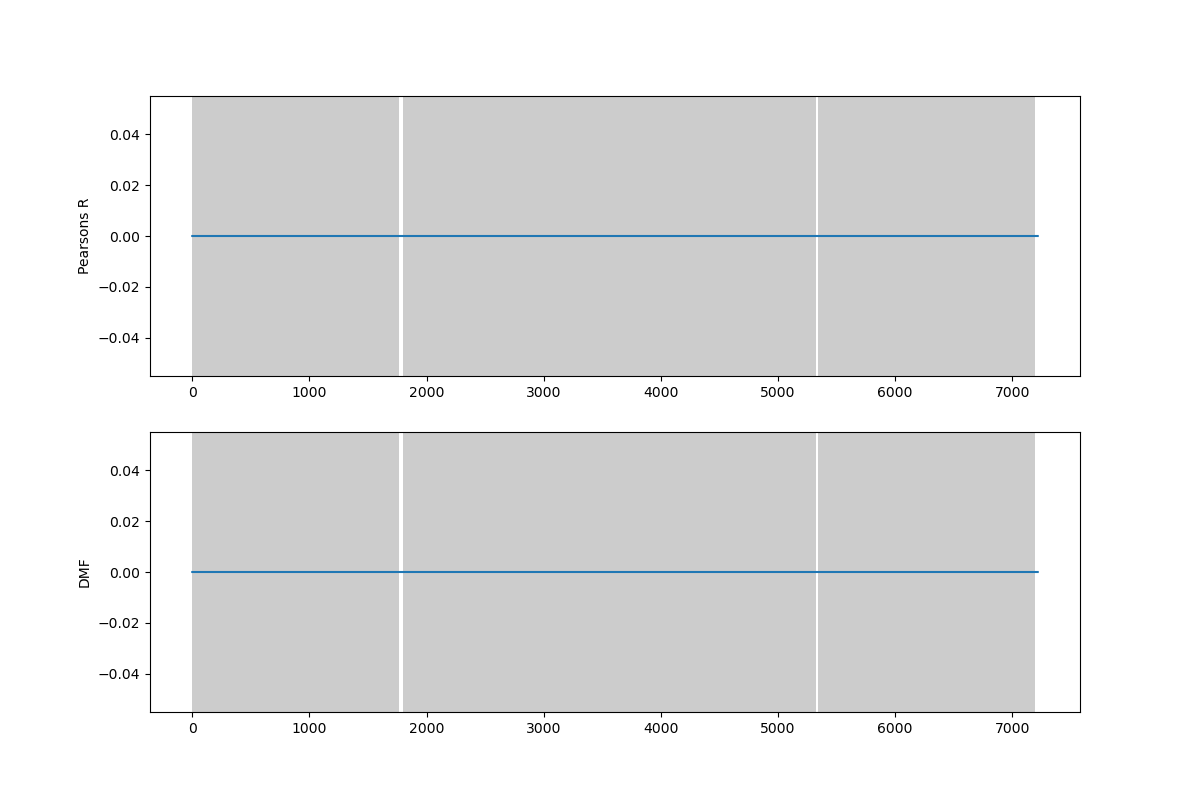

In [27]:
from cupyx.scipy.ndimage import maximum_filter, median_filter, convolve1d

r_thresh = 0.89
dmf_thresh = 0.0039

fig, axs = plt.subplots(2,1,figsize=(12,8))
ax = axs.flatten()
metrics = reg["metrics"].T
r = metrics[0]
ax[0].plot(r)
ax[0].set_ylabel("Pearsons R")
dmf =(maximum_filter(median_filter(cp.asarray(r), 3), size=21) - cp.asarray(r)).get()
ax[1].plot(dmf)
ax[1].set_ylabel("DMF")
trace_mask = np.ones_like(metrics[0], dtype = bool)
trace_mask[(dmf > dmf_thresh) | (r < r_thresh) | np.isnan(r)] = 0

neighbor_sum = convolve1d(cp.asarray(trace_mask).astype(cp.int8), weights=cp.array([1, 1, 1]), mode='constant', cval=0).get()
trace_mask = trace_mask ^ ((trace_mask == True) & (neighbor_sum == 1))

trace_mask = np.ones(shape=(7219,))
trace_mask[1764:1796]=0
trace_mask[5322:5342]=0
trace_mask[7198:]=0
trace_mask = trace_mask.astype(bool)



diff = np.diff(np.concatenate(([False], trace_mask, [False])).astype(int))

# Find the start and end frame indices of each shaded region
starts_idx = np.where(diff == 1)[0]
ends_idx = np.where(diff == -1)[0]



for start, end in zip(starts_idx, ends_idx):
    # axvspan draws a vertical rectangle from start_time to end_time
    ax[0].axvspan(start,end, color='gray', alpha=0.4,zorder=0,linewidth=0  )
    ax[1].axvspan(start,end, color='gray', alpha=0.4,zorder=0,linewidth=0  )
# Redraw the figure to show the new spans
fig.canvas.draw()

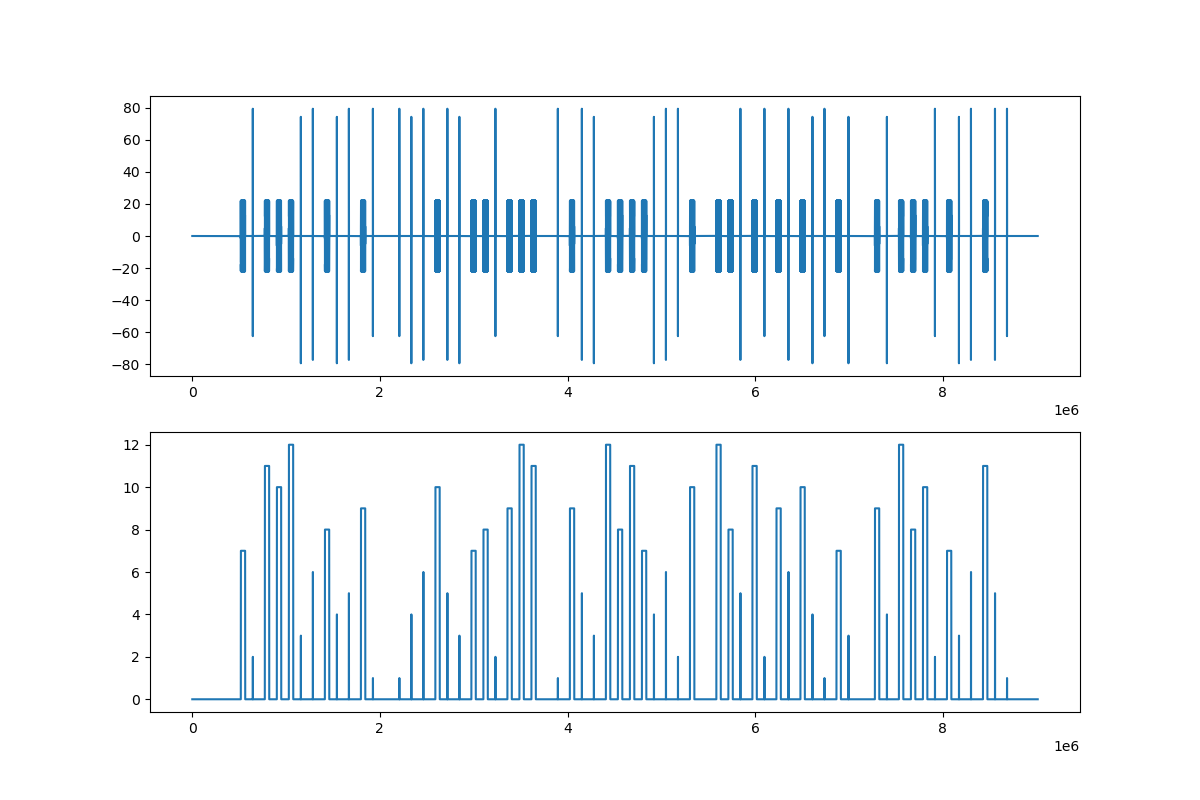

In [39]:
import json
import os
from collections import defaultdict

stim_label = {0: "",#Silence',
 1: "R_GT_400hz",#gammatone_4e+02Hz_79Pa-1pi_2.7ms2-1pi_angle90.0',
 2: 'L_GT_400hz',#'gammatone_4e+02Hz_79Pa-1pi_2.7ms2-1pi_angle270.0',
 3: 'R_GT_800hz',#'gammatone_8e+02Hz_79Pa-1pi_2.7ms2-1pi_angle90.0',
 4: 'L_GT_800hz',#'gammatone_8e+02Hz_79Pa-1pi_2.7ms2-1pi_angle270.0',
 5: 'R_GT_1200hz',#'gammatone_1.2e+03Hz_79Pa-1pi_2.7ms2-1pi_angle90.0',
 6: 'L_GT_1200hz',#'gammatone_1.2e+03Hz_79Pa-1pi_2.7ms2-1pi_angle270.0',
 7: 'R_sin_400hz',#tone_0.9s_400Hz_22PaMonopoleWave2D_distance0.03m_angle90.0',
 8: 'L_sin_400hz',#'tone_0.9s_400Hz_22PaMonopoleWave2D_distance0.03m_angle270.0',
 9: 'R_sin_800hz',#'tone_0.9s_800Hz_22PaMonopoleWave2D_distance0.03m_angle90.0',
 10: 'L_sin_800hz',#'tone_0.9s_800Hz_22PaMonopoleWave2D_distance0.03m_angle270.0',
 11: 'R_sin_1200hz',#'tone_0.9s_1200Hz_22PaMonopoleWave2D_distance0.03m_angle90.0',
 12: 'L_sin_1200hz',#'tone_0.9s_1200Hz_22PaMonopoleWave2D_distance0.03m_angle270.0'
             }

fps=40
stim_data = lazyh5(os.path.expanduser(os.path.join(pn_rec, "stimset_LB_zf1", "stimdata_conditioned.h5")))
# stim_data = lazyh5(os.path.expanduser("~/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1/stimdata_conditioned.h5"))
samplerate = stim_data["spec"]["samplerate"]
reverb_time = int(stim_data["spec"]["reverb_period"]*samplerate)

stimdict = {}
stim_names = {}
for i in range(13):
    stimdict[i] = stim_data["stimulus_collection"][str(i)]["stimulus"]
    stim_names[i]=stim_data["spec"]["stimuli"][str(i)]["label"]

with open(os.path.expanduser(os.path.join(pn_rec, "stimset_LB_zf1", "stimulus_assembly_info.json")), 'r') as f:
    stim_json = json.load(f)

stimulus_sequence_order = stim_json.get('stimulus_sequence_order', [])
stimulus_onsets = defaultdict(list)
assembly_info = stim_json.get('assembly_info', [])
total_duration = stim_json.get("assembly_duration",[])

final_stimulus = np.zeros(int(total_duration*samplerate))
final_stimulus_id = np.zeros(int(total_duration*samplerate))

# Iterate through each event in the assembly
for i, event_info in enumerate(assembly_info):
    stim_id = stimulus_sequence_order[i]
    # Get the 'onset' time for this event
    onset_time = round(event_info.get('onset')*samplerate)
    offset_time = round(event_info.get("offset")*samplerate)
    stimulus_onsets[stim_id].append(onset_time)
    if stim_id!=0:
        final_stimulus[onset_time:offset_time] = stimdict[stim_id][reverb_time:-reverb_time]
        final_stimulus_id[onset_time:offset_time] = stim_id
    
fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(final_stimulus)
ax[1].plot(final_stimulus_id)


final_stimulus_id_fps = np.zeros(shape=(7219,),dtype=np.uint8)
final_stimulus_id_fps[:final_stimulus_id[::int(samplerate/fps)].shape[0]] = final_stimulus_id[::int(samplerate/fps)]
stim_labels=[stim_label[id] for id in final_stimulus_id_fps]


In [41]:
stimulus = final_stimulus_id_fps != 0

In [23]:
np.save("/home/lubo12/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1/stim_labels.npy", stim_labels)

OSError: [Errno 30] Read-only file system: '/home/lubo12/hpc-r/lfm2025/recordings/2025_0818_zf_audiostim/stimset_LB_zf1/stim_labels.npy'

In [93]:
from i_o import VolumeReader
import cupyx
reader = VolumeReader(paths.registered, "data")

traces = []
for i_frame,vol in tqdm(reader):
    vol = cupyx.scipy.ndimage.convolve(cp.asarray(vol), softball_kernel) 
    traces.append(vol[peaks].get())
traces = np.array(traces).T

KeyboardInterrupt: 

<Axes: >

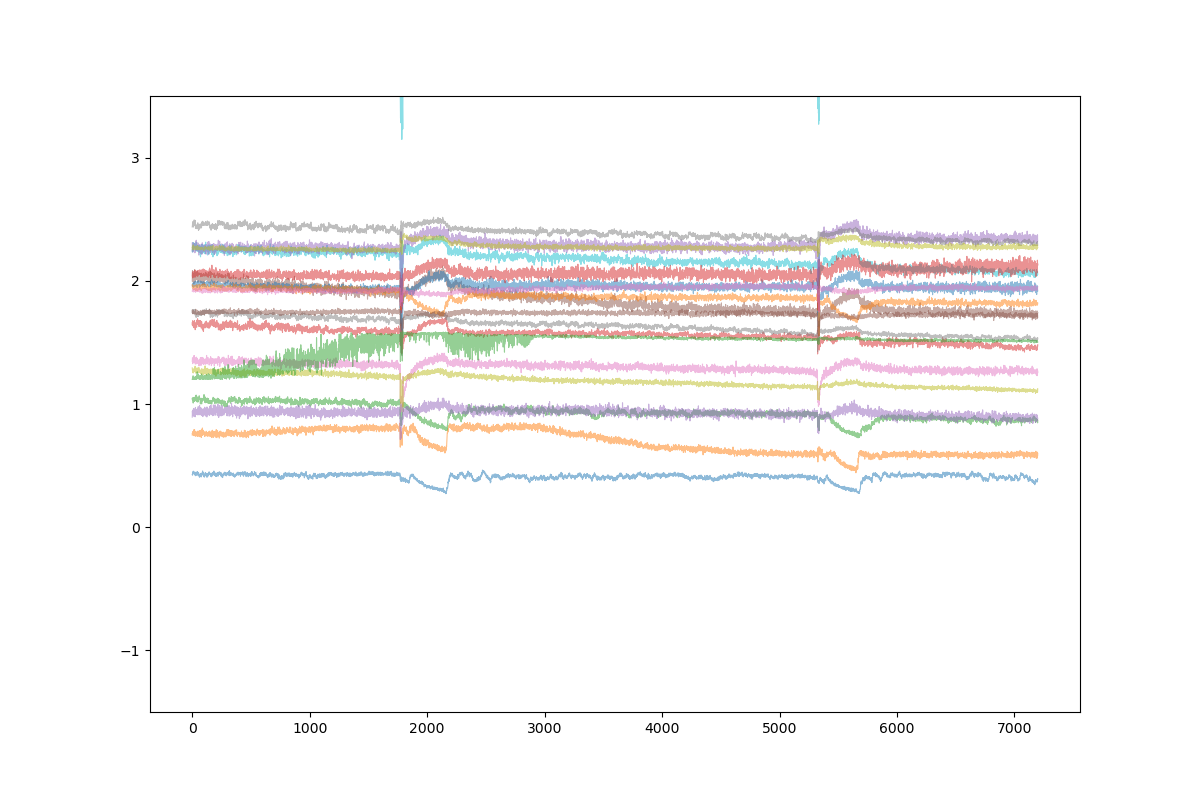

In [174]:
from util import plot_traces
idx = np.random.choice(np.arange(traces_mean.shape[1]), 20)
fig, ax = plt.subplots(1,2,figsize=(14,8))
plot_traces(traces_kernel[:7200, idx], np.ones(shape=[7200]), n=20,ax=ax, scale_factor = 0.1, y_add = 1.5)#
# ax.set_ylim(1.5,5.5)

(1112,) 20250701_1501_LB_ZF_v552_f3_40fps_2


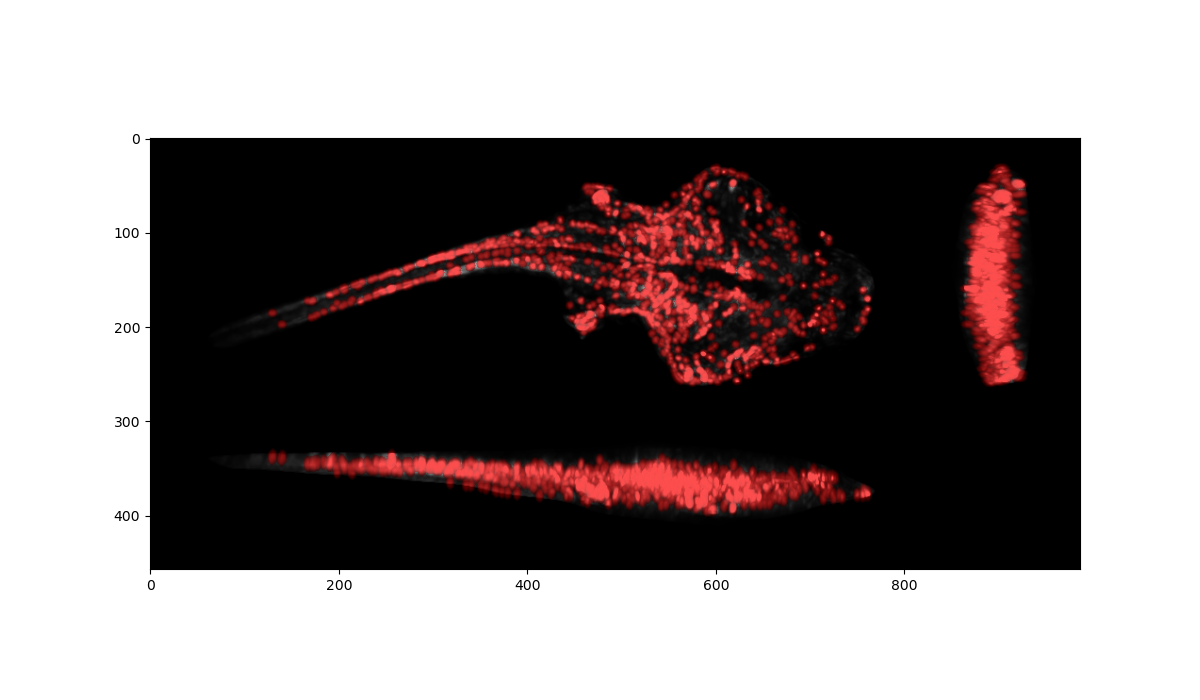

In [7]:
import signal_extraction
importlib.reload(signal_extraction)
from signal_extraction import dogfilter_gpu, findmaxima_gpu, soft_ball, create_projection_image_with_peaks, save_segmentation_result_tif

min_search_radius=[1,1,1]
min_peak_brightness = 0.003
softball_shape = [6,3.5,3.5]
softball_k = 2

# cov_map_f = dogfilter_gpu(reg["cov_map"], sigma_low = [0.5,0.5,0.5], sigma_high = [4,4,4])
maxima_bool, peaks, peak_vals = findmaxima_gpu(cov_map_f, radius = min_search_radius, thresh = min_peak_brightness)
softball_kernel = cp.array(soft_ball(softball_shape, k=softball_k), 'float32')
softball_kernel /= softball_kernel.sum()

fig, ax = plt.subplots(1,1,figsize=(12,7))
# n=4
# peaks_subset= (peaks[0][2::n],peaks[1][2::n],peaks[2][2::n])
ax.imshow(create_projection_image_with_peaks(reg["cov_map"], peaks, vmax=5, marker_radius = softball_shape, marker_k = softball_k, marker_intensity=0.8, transpose= True))
rgb = save_segmentation_result_tif(reg["cov_map"], peaks, output_fn = , marker_radius=softball_shape,marker_k=softball_k,vmax=2*min_peak_brightness) #os.path.expanduser(os.path.join(paths.pn_outrec,"segmentation.tif"))
# tifffile.imwrite("test.tif", rgb.get(), imagej=True)
print(peaks[0].shape, paths.dataset_name)